# Support vector machines (SVMs)

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from addutils import css_notebook
css_notebook()

## 1 Introduction

*Support vector machines (SVMs)* is a supervised learning algorithm, primarily designed for classification that has been for a long period of time one of the most successful algorithm in ML. They are a good method because there is an intuition behind their formulation and the algorithm can be solved with optimization, and the solution can be interpreted intuitively.

In the following section we will introduce the following notions:
- Maximizing the margin
- The solution
- Kernel trick
- Soft margin SVMs

### 1.1 Better Linear Separation

Suppose that you have a dataset with linearly separable data. You could use several separating lines. If I look at the lines we can see their margin, we can ask ourselves, if I move the line a bit when is it too close than it can crossover (that is making an error)?

*Which line (margin) is the best?*

<img src="images/better_linear_separation.png" alt="Better Linear Separation" height="500" width="500"> 

It is tempting to say that bigger margin is better. Suppose you have a process that generates the data that has some noise. If the margin is bigger there could be more chance to correctly classify noisy data.

Two question are worth answering:
- Why bigger margin is better?
- Which $w$ maximize the margin?

### 1.2 Bigger margin is better

Suppose we want to classify a set of three points in the plane, using a line. A single line can separate all possible combinations of points?

<img src="images/dichotomies.png" alt="Dichotomies" height="500" width="500"> 

Yes, it can. In a sense it has a low bias, all possible functions that can generate those three points can be learned. But this could be bad (remeber bias variance tradeoff?) and can lead to bad generalization.

If we can restrict the line to be the ones that have fat margin? Can we increase the bias (decrease variance) and generalize better?

<img src="images/dichotomies_fat.png" alt="Dichotomies fat margin" height="500" width="500">

Suppose you can use only the lines that have a margin with at least a specific (fat) size to accept it. By putting a restriction on the dimension of the margin the model gets simpler (higher bias).

(Actually this example refers to the theory of [**VC dimension**](https://en.wikipedia.org/wiki/VC_dimension))

### 1.3 Find the plane with bigger margin

<img src="images/maximize_margin.png"  alt="Margins" height="500" width="500">

Recall that the distance from a point($x_0 ,y_0)$ to a line $Ax+By+c = 0$ is: 

$$\frac{|A x_0 + B y_0 +c|}{\sqrt{(A^2 +B^2)}}$$

The distance between H and H1 is:

$$\frac{|w\cdot x+b|}{||w||}=\frac{1}{||w||}$$

The distance between H1 and H2 is: 

$$\frac{2}{||w||}$$

In order to maximize the margin, we need to minimize $||w||$, with the condition that there are no datapoints between H1 and H2:

$$
x_i \cdot w+b \geq +1 \rightarrow y_i =+1\\
x_i \cdot w+b \leq -1 \rightarrow y_i =-1
$$

Can be combined into 

$$y_i (x_i \cdot w + b) \geq 1$$

The maximal margin touches some of the points, but it does not have points inside. The points that do not lie to either side of the margin are called interior points.

The problem is: minimize $||w||$, such that discrimination boundary is obeyed, i.e., min f(x) s.t. g(x)=0, where:

$$
f: \frac{1}{2} ||w||^2 \\
g: y_i (x_i \cdot w)+b = 1 \quad or \quad [y_i (x_i \cdot w)+b] - 1 =0
$$

This is a constrained optimization problem that can be solved by Lagrangian multipler method and quadratic programming. We will not dig into the mathematical details of the solution because it will require a lot of time with many passages, please refer to [this](https://www.svm-tutorial.com/) if you want all the details. We will only sketch the solution because we will use it later on for the derivation of the kernel method and the soft margin version of SVM.

This is the formulation of the lagrangian multiplier method:

$$L ( x , \alpha ) = f ( x ) + \sum_i \alpha_i g_i ( x )$$ 

$f(x)$ is the gradient max of $f$ and $g$ is the constraint condition. In our case, $f(x): \frac{1}{2}||w||^2$ and $g(x): y_i (w\cdot x_i +b)-1=0$ so the (primal) Lagrangian for SVM is:

$$
\mathcal{L}(w,b,\alpha) \equiv \frac{1}{2}||w||^2 - \sum_i \alpha_i y_i (x_i \cdot w + b) + \sum_i \alpha_i \\
\alpha_i \geq 0,\quad \forall i
$$

Putting the derivatives equal to zero we get:
$$
w = \sum_i \alpha_i y_i x_i, \quad \sum_i \alpha_i y_i = 0 \\
$$

In order to solve this maximization problem we have to switch to its dual formulation. Substituting the gradient and the constraint in the lagrangian we obtain:

$$
\mathcal{L}(\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_j \sum_i y_j y_i \alpha_j \alpha_i  x_j \cdot x_i   
$$

subject to:

$$
\alpha_i \geq 0, \quad \sum_i \alpha_i y_i = 0
$$

This is a simple quadratic form in the vector alpha. $w$ does not appear in optimization so it is only the result (that is I find alphas and then compute $w$).

The solution of this optimization is quadratic programming. There are packages already available for solving quadratic programming problems, but we have to switch to a minimization problem. This is easily done by changing the sign of the equation. 

$$
min_\alpha \quad  \frac{1}{2} \alpha \cdot Q \alpha - 1 \cdot \alpha
$$

subject to:

$$
\alpha_i \geq 0, \quad \alpha \cdot y = 0
$$

where Q is the matrix of quadratic coefficients (and the vector $-1$ is the linear term):

<img src="images/quadratic_svm.png"  alt="Margins" height="500" width="500">

the quadratic programming package will take the matrix of coefficient and return the vector of alphas that minimize that quantity. The vector of alphas has the same lenght as the number of examples. The vector comes with a surprise, most of the alphas are zero!

Now we want to get the solution, that is the vector of $w$, remember? Our separating hyperplane. How do we get that? By plugging alphas in the equation 

$$w = \sum_i \alpha_i y_i x_i$$

The problem formulation has a nice condition, the quantity:

$$\alpha_i ( y_i (x_i \cdot w + b) - 1) = 0$$

so either the alpha is zero or the remaining term is zero! If the other term is positive, we are talking about an interior point, this equation guaranties that the corresponding alpha is zero. If in the other case alpha is positive the corresponding point is called **support vector**!

$\alpha_i > 0 \implies x_i$ is a **support vector**

<img src="images/svm.png"  alt="Margins" height="500" width="500">

### 1.4 Kernel Trick

<img src="images/non_separable_svm.png"  alt="Margins" height="500" width="500">

This formulation albeit interesting leaves us with one question. How do I apply SVM to the nonlinear case? 

Recall linear regression. In order to go nonlinear we had to transform the features. That is we passed from a feature space $\mathcal{X}$ to a feature space $\mathcal{Z}$. Can we apply the same transformation to the SVM? How does the problem formulation changes?

<img src="images/non_linear_svm.png"  alt="Margins" height="500" width="500">

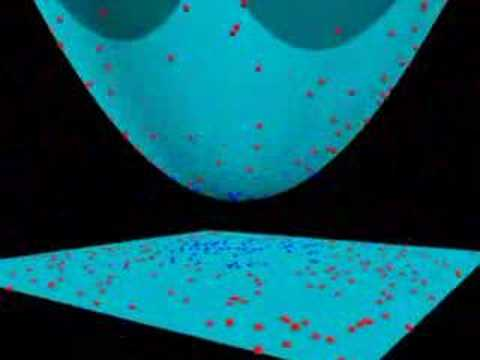

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('3liCbRZPrZA', width=800, height=420)

$$\mathcal{L}(\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_j \sum_i y_j y_i \alpha_j \alpha_i  z_j \cdot z_i$$

Suppose that the new space has higher dimension. Does it change the equation? No, because it is an inner product. We have only one number at the end! The number of alphas (the number of data points) remains the same. The $w$ however will belong to the $\mathcal{Z}$ space. Do I have also the support vector in the $\mathcal{X}$? They are not support vector any more, they are called "pre-images" of support vector (they are the closest to the margin) but the margin is maintained in the $\mathcal{Z}$ space.

The nice thing about this is: we don't need to compute the vectors $z_i$ and $z_j$ in the $\mathcal{Z}$ space but only the dot product. So the mathematical computation involve $x_i$ and $x_j$ and gives the correct result in $\mathcal{Z}$.

What do I need from the $\mathcal{Z}$ space, so that its dimensionality does not appear? I need to calculate the inner product, $\alpha_i  z_j \cdot z_i$, but the good news is that it is actually less demanding than transforming the vectors in from the $\mathcal{X}$ space. We do not need anything else from the $\mathcal{Z}$ space other than the inner product. Is it true? What about the output of the model?

$$g(x) = sign(w \cdot z + b)$$

but 

$$w = \sum_{z_i \in SV} \alpha_i y_i z_i$$

substituting we need only 

$$z \cdot z_i$$

the same occurs for b, I can use any equation in the form $y_j(w \cdot z_j + b) = 1$ substitute $w$ and again I get $z_j \cdot z_i$

I can even move forward. Now I'm computing the inner product without visiting the $\mathcal{Z}$ space, but I can compute the inner product even without knowing what the $\mathcal{Z}$ space is. 

Now let's see how to do that. We define the **kernel** as a generalized inner product, that is an inner product after a transformation:

$$z \cdot z' = K(x, x')$$

<img src="images/kernel_svm.png"  alt="Margins" height="500" width="500">

### 1.5 Soft margin SVMs

### 1.6 Advantages and Disadvantages

**Advantages**:
- "The key features of SVMs are the use of kernels, the absence of local minima, the sparseness of the solution and the capacity control obtained by optimising the margin." Shawe-Taylor and Cristianini (2004) 

**Disadvantages**:
- v"Perhaps the biggest limitation of the support vector approach lies in choice of the kernel." Burgess (1998)

- "A second limitation is speed and size, both in training and testing." Burgess (1998)

- "Discete data presents another problem..." Burgess (1998)

- "...the optimal design for multiclass SVM classifiers is a further area for research." Burgess (1998)

- "Although SVMs have good generalization performance, they can be abysmally slow in test phase, a problem addressed in (Burges, 1996; Osuna and Girosi, 1998)." Burgess (1998)

- "Besides the advantages of SVMs - from a practical point of view - they have some drawbacks. An important practical question that is not entirely solved, is the selection of the kernel function parameters - for Gaussian kernels the width parameter [sigma] - and the value of [epsilon] in the [epsilon]-insensitive loss function...[more]" Horváth (2003) in Suykens et al.

- "However, from a practical point of view perhaps the most serious problem with SVMs is the high algorithmic complexity and extensive memory requirements of the required quadratic programming in large-scale tasks." Horváth (2003) in Suykens et al. p 392

## 2 SVM for Classification

`SVC and NuSVC` are similar methods, but accept slightly different sets of parameters and have different mathematical formulations (see section Mathematical formulation). `LinearSVC` is another implementation of Support Vector Classification for the case of a linear kernel.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

In [6]:
from matplotlib.colors import ListedColormap
from pandas.tools.plotting import scatter_matrix
from sklearn import svm, datasets, preprocessing, neighbors, model_selection

d = datasets.load_iris()  
X = pd.DataFrame(d.data, columns=d.feature_names)
y = d.target
print(X.columns)

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')


In [7]:
from sklearn import svm, datasets

iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
h = .02               # step size in the mesh
C = 1.0               # SVM regularization parameter

std_svc = svm.SVC(kernel='linear', C=C).fit(X,y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X,y)
pol_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X,y)
lin_svc = svm.LinearSVC(C=C).fit(X,y)

In [8]:
import addutils.palette as pal
import seaborn as sns
from bokeh.models.mappers import LinearColorMapper

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xs = np.arange(x_min, x_max, h*2)
ys = np.arange(y_min, y_max, h*2)
xx, yy = np.meshgrid(xs, ys)
xx = xx.ravel()
yy = yy.ravel()

titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'LinearSVC (linear kernel)']

grid = []
palette = list(map(pal.to_hex, sns.color_palette('Paired', 6)))
palette_dots = palette[1::2]    # colours in odd indices 
palette_patches = palette[::2]  # colours in even indices
# Bokeh understands the mapping interval for the colors as open on the high side.
# So we have to customize the color mapper, and raise the upper limit a bit
# to prevent Bokeh from discarding any colours. 
# max(Z) is 2, so 2.1 is fine for the upper limit.
patches_cmapper = LinearColorMapper(low=0, high=2.1, palette=palette_patches)

for i, clf in enumerate((std_svc, rbf_svc, pol_svc, lin_svc)):
    # Plot the decision boundary assigning a color to each point in the mesh
    Z = clf.predict(np.c_[xx, yy])
    Z = Z.reshape((ys.size, xs.size))
    
    # Plot the training points
    fig = bk.figure(plot_width=360, plot_height=280, title=titles[i],
                   x_range=(x_min, x_max), y_range=(y_min, y_max))
    fig.title.text_font_size = '10pt'
    fig.axis.major_label_text_color = None
    fig.axis.major_tick_line_color = None
    fig.axis.minor_tick_line_color = None
    fig.image(image=[Z*0.99 + 0.1], x=[x_min], y=[y_min], 
              dw=[x_max-x_min], dh=[y_max-y_min],
              color_mapper=patches_cmapper)
    fig.scatter(X[:, 0], X[:, 1], size=6,
                line_color='black', line_alpha=0.5,
                fill_color=[ palette_dots[j] for j in y ])
    grid.append(fig)
    
bk.show(bk.gridplot([[grid[0], grid[1]], [grid[2], grid[3]]]))

## 3 SVM for Regression

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.

The model produced by support vector classification (as described above) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.

As with classification classes, the fit method will take as argument vectors X, y, only that in this case y is expected to have floating point values instead of integer values:

In [9]:
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
svm_svr = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                  epsilon=0.1, gamma='auto', kernel='rbf',
                  shrinking=True, tol=0.01, verbose=False)
svm_svr.fit(X, y) 
svm_svr.predict([[1, 1]])

array([ 1.5])

**Support Vector Regression (SVR) using linear and non-linear kernels:** this is a simple example of 1D regression using linear, polynominial and RBF kernels.



In [10]:
# Generate data and add noise to target
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

###############################################################################
# look at the results
fig = bk.figure(plot_width=600, plot_height=500, title="Support Vector Regression")
fig.title.text_font_size = '12pt'
fig.scatter(X[:,0], y, color='black', legend='data', size=8)
fig.line(X[:,0], y_rbf, color='green', legend='RBF model')
fig.line(X[:,0], y_lin, color='red', legend='Linear model')
fig.line(X[:,0], y_poly, color='blue', legend='Polynomial model')
fig.xaxis.axis_label = 'data'
fig.yaxis.axis_label = 'target'
fig.axis.axis_label_text_font_size = '11pt'
bk.show(fig)

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.